In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

## Ensure GPU is running

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(f"Num of GPUs: {len(physical_devices)}")
assert len(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num of GPUs: 1


In [3]:
# Download preprocessed dataset from Google drive

In [4]:
# Define the path to the training dataset
train_path = '/kaggle/input/laguna-dataset-preprocessed/train'
valid_path = '/kaggle/input/laguna-dataset-preprocessed/valid'
test_path = '/kaggle/input/laguna-dataset-preprocessed/test'

In [6]:
# Define an ImageDataGenerator for data augmentation and preprocessing using ResnNt50 settings
train_datagen = ImageDataGenerator(
    rotation_range=15,  # Increased rotation range
    width_shift_range=0.15,  # Increased shift range
    height_shift_range=0.15,  # Increased shift range
    shear_range=0.2,  # Increased shear range
    zoom_range=0.15,  # Increased zoom range
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [7]:
# Define an ImageDataGenerator for data augmentation and preprocessing using ResNet50 settings

# Apply data augmentation to the training batch
train_batches = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224), classes=['Healthy', 'Bunchy top', 'Black sigatoka'], batch_size=10)


# Create a flow_from_directory generator for the validation dataset
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Healthy', 'Bunchy top', 'Black sigatoka'], batch_size=10)

# Create a flow_from_directory generator for the test dataset without shuffling
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Healthy', 'Bunchy top', 'Black sigatoka'], batch_size=10, shuffle=False)

Found 627 images belonging to 3 classes.
Found 177 images belonging to 3 classes.
Found 79 images belonging to 3 classes.


In [8]:
print(train_batches.n) 
print (valid_batches.n)
print (test_batches.n)
print(train_batches.num_classes, valid_batches.num_classes, test_batches.num_classes)

assert train_batches.n == 627
assert valid_batches.n == 177
assert test_batches.n == 79
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

627
177
79
3 3 3


In [9]:
imgs, labels = next(train_batches)

In [10]:
# Plot the images in a form of grid with 1 row and 10 columns where images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

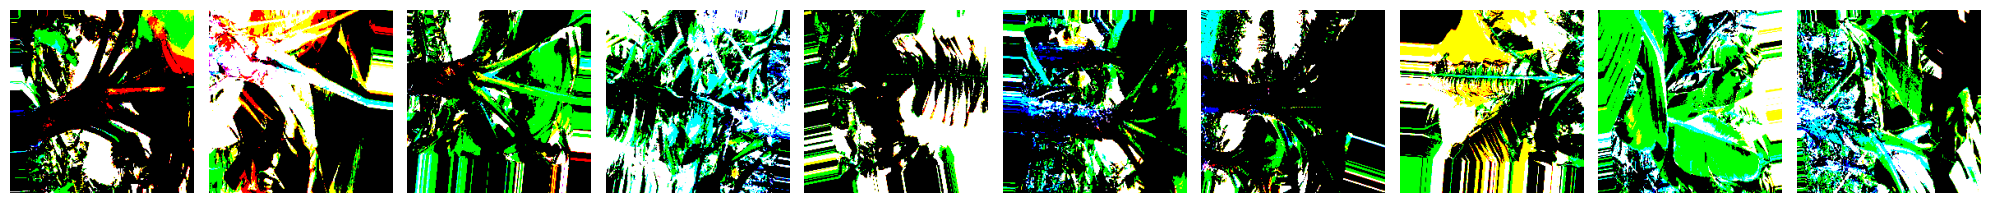

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [11]:
# Plot the images in 'imgs' and print the corresponding labels

# Call the previously defined function 'plotImages' to display the images
plotImages(imgs)

# Print the labels corresponding to the displayed images
print(labels)


In [12]:
# Download model - Internet connection needed
resnet_model = tf.keras.applications.ResNet50()

102967424/102967424 [==============================] - 1s 0us/step


In [13]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {"non_trainable_params": non_trainable_params, "trainable_params": trainable_params}

In [17]:
x = resnet_model.layers[-1].output




output = Dense(units=3, activation='softmax')(x)

# len(model.layers)


In [18]:
model = Model(inputs=resnet_model.input, outputs=output)

In [19]:
len(model.layers)

178

In [20]:
for layers in model.layers[:-125]:
    layers.trainable = False

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [22]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

In [23]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [24]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("/kaggle/working/best_model.h5", monitor="val_accuracy", save_best_only=True)

In [25]:
history = model.fit(
    x=train_batches, 
    validation_data=valid_batches, 
    epochs=10, 
    verbose=2, 
    callbacks=[
        early_stop,
        checkpoint
    ]
)



Epoch 1/10
63/63 - 155s - loss: 1.0708 - accuracy: 0.6571 - val_loss: 1.0444 - val_accuracy: 0.7288 - 155s/epoch - 2s/step
Epoch 2/10
63/63 - 74s - loss: 1.0321 - accuracy: 0.8262 - val_loss: 1.0266 - val_accuracy: 0.8305 - 74s/epoch - 1s/step
Epoch 3/10
63/63 - 74s - loss: 1.0182 - accuracy: 0.8453 - val_loss: 1.0113 - val_accuracy: 0.8588 - 74s/epoch - 1s/step
Epoch 4/10
63/63 - 73s - loss: 1.0076 - accuracy: 0.8628 - val_loss: 1.0094 - val_accuracy: 0.8249 - 73s/epoch - 1s/step
Epoch 5/10
63/63 - 73s - loss: 1.0011 - accuracy: 0.8485 - val_loss: 1.0036 - val_accuracy: 0.8192 - 73s/epoch - 1s/step
Epoch 6/10
63/63 - 72s - loss: 0.9936 - accuracy: 0.8565 - val_loss: 0.9990 - val_accuracy: 0.8079 - 72s/epoch - 1s/step
Epoch 7/10
63/63 - 73s - loss: 0.9790 - accuracy: 0.8979 - val_loss: 0.9792 - val_accuracy: 0.8701 - 73s/epoch - 1s/step
Epoch 8/10
63/63 - 73s - loss: 0.9727 - accuracy: 0.8963 - val_loss: 0.9756 - val_accuracy: 0.8588 - 73s/epoch - 1s/step
Epoch 9/10
63/63 - 72s - loss:

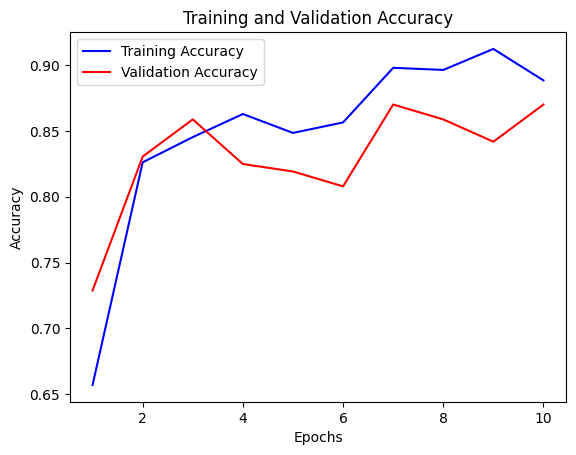

In [26]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)
# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b',label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

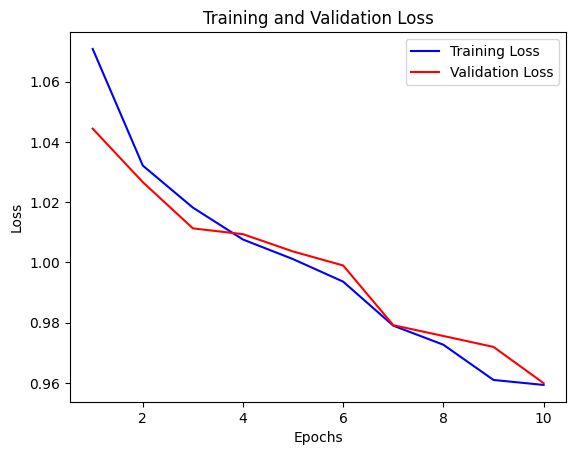

In [27]:
train_accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

# Create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)
# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b',label='Training Loss')
plt.plot(epochs, val_accuracy, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [28]:
predictions = model.predict(x=test_batches, verbose=0)

In [29]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [30]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [31]:
test_batches.class_indices

{'Healthy': 0, 'Bunchy top': 1, 'Black sigatoka': 2}

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape [0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[40  0  2]
 [ 2 13  2]
 [ 2  3 15]]


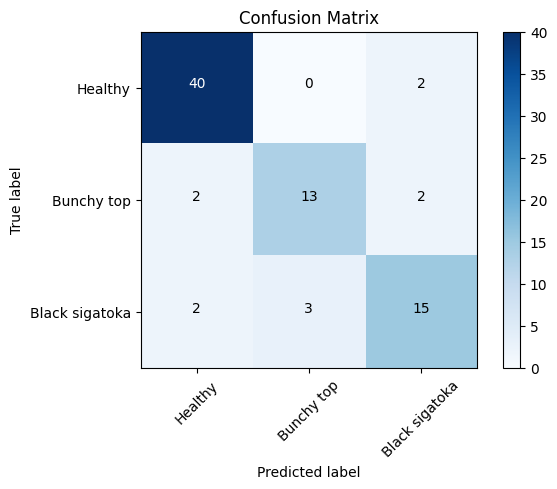

In [33]:
cm_plot_labels = ["Healthy", "Bunchy top", "Black sigatoka"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [34]:
accuracy = accuracy_score(test_batches.classes, np.argmax(predictions, axis=1))

accuracy_percentage = accuracy * 100.0

print(f"Test Accuracy: {accuracy_percentage:.2f}")

Test Accuracy: 86.08


In [35]:
# Get the class labels for the images in the test set
test_classes = test_batches.classes

# Make predictions on the test set
predictions = model.predict(x=test_batches, verbose=0)

# Convert the predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=-1)

# Get the filenames of the test images
filenames = test_batches.filenames

# Print out images along with their true and predicted labels
for i in range(len(filenames)):
    print(f"True Label: {test_classes[i]}, Predicted Label: {predicted_classes[i]}, File Name: {filenames[i]}")

True Label: 0, Predicted Label: 0, File Name: Healthy/012deac3-4ca6-4663-b7ba-de1de8d03ed1.jpg
True Label: 0, Predicted Label: 0, File Name: Healthy/0b71b04b-c0b8-490e-b96d-1e1db7e6b115.jpg
True Label: 0, Predicted Label: 0, File Name: Healthy/0feebc4b-b3b9-46e1-bc5a-176524483824.jpg
True Label: 0, Predicted Label: 0, File Name: Healthy/1a3507da-4d51-4ee2-ac2a-244dbbdc28ba.jpg
True Label: 0, Predicted Label: 0, File Name: Healthy/2343a07b-ee17-447f-98e5-40a1b19ad4f3.jpg
True Label: 0, Predicted Label: 0, File Name: Healthy/27490054-6467-463e-ab2b-d02c992440dd.jpg
True Label: 0, Predicted Label: 0, File Name: Healthy/2bd58831-f694-4b93-903b-24da463f1943.jpg
True Label: 0, Predicted Label: 2, File Name: Healthy/2e51303e-afa9-4b31-b6c6-74970b2365be.jpg
True Label: 0, Predicted Label: 0, File Name: Healthy/304ad582-305b-4a63-85b3-6831db0e3f34.jpg
True Label: 0, Predicted Label: 0, File Name: Healthy/31d5636d-402a-4e06-b675-ec010c461610.jpg
True Label: 0, Predicted Label: 0, File Name: Heal

In [36]:
try:
    model.save(f'laguna_banana_model{accuracy_percentage:.2f}.h5')
    print("Model saved successfully.")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Model saved successfully.
